In [26]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
# Import necessary libraries
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from transformers import GPT2Config, GPT2Model
from tqdm import tqdm, trange
# from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup, AdamW
# Initialize the GPT-2 model and tokenizer
# tokenizer = GPT2Tokenizer.from_config(GPT2Config())
# model = GPT2LMHeadModel.from_config(GPT2Config())

In [11]:
# Define the configuration
config = GPT2Config(
    vocab_size=27,
    n_positions=128,
    n_ctx=1024,
    n_embd=768,
    n_layer=12,
    n_head=12,
    activation_function='gelu_new',
    resid_pdrop=0.1,
    embd_pdrop=0.1,
    attn_pdrop=0.1,
    layer_norm_epsilon=1e-5,
    initializer_range=0.02,
    summary_type='cls_index',
    summary_use_proj=True,
    summary_activation=None,
    summary_proj_to_labels=True,
    summary_first_dropout=0.1,
    bos_token_id=50256,
    eos_token_id=50256,
    gradient_checkpointing=False,
)
# Create the model
model = GPT2Model(config)

In [2]:
data_dir = '/n/home12/binxuwang/Github/DiffusionReasoning/'
attr_all = np.load(data_dir+'attr_all.npy')
print(attr_all.shape)

(40, 12000, 3, 9, 3)


In [3]:
def preprocess_ids(attr_seq_tsr, ):
    """ Add 1 to all attribute values, such that -1 becomes 0. 
    then the index is valid as token. """
    attr_seq_tsr_pps = attr_seq_tsr.clone() + 1
    return attr_seq_tsr_pps

attr_all_rows = torch.tensor(attr_all)
attr_tsr = einops.rearrange(attr_all_rows,  'class (B R) p (h w) attr -> class B attr (R h) (p w)', h=3,w=3,p=3,R=3)
attr_seq_tsr = einops.rearrange(attr_tsr,  'class B attr (R h) (p w) -> (class B) (R p h w) attr', h=3,w=3,p=3,R=3)
attr_seq_tsr_pps = preprocess_ids(attr_seq_tsr)

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/einops/parsing.py:136: RuntimeWarning: It is discouraged to use axes names that are keywords: class
  warnings.warn("It is discouraged to use axes names that are keywords: {}".format(name), RuntimeWarning)


In [4]:
class SepWordEmbed(nn.Module):
    def __init__(self, embed_dims=(7,10,10), embed_size=256):
        super(SepWordEmbed, self).__init__()
        self.embedding1 = nn.Embedding(embed_dims[0]+1, embed_size)
        self.embedding2 = nn.Embedding(embed_dims[1]+1, embed_size)
        self.embedding3 = nn.Embedding(embed_dims[2]+1, embed_size)

    def forward(self, attr_seq_tsr):
        # split the attr_seq_tsr into three parts along the last dimension
        # attr_seq_tsr_1, attr_seq_tsr_2, attr_seq_tsr_3 = torch.split(attr_seq_tsr, [1,1,1], dim=-1)
        attr_seq_tsr_1, attr_seq_tsr_2, attr_seq_tsr_3 = attr_seq_tsr[...,0], attr_seq_tsr[...,1], attr_seq_tsr[...,2]
        # attr_seq_embed = self.embedding1(attr_seq_tsr_1) + self.embedding2(attr_seq_tsr_2) + self.embedding3(attr_seq_tsr_3)
        attr_seq_embed = th.concat([self.embedding1(attr_seq_tsr_1), 
                                    self.embedding2(attr_seq_tsr_2), 
                                    self.embedding3(attr_seq_tsr_3)], dim=-1)
        return attr_seq_embed
    
class SepLMhead(nn.Module):
    def __init__(self, embed_dims=(7,10,10), embed_size=256):
        super(SepLMhead, self).__init__()
        self.embed_size = embed_size
        self.lmhead1 = nn.Linear(embed_size, embed_dims[0]+1)
        self.lmhead2 = nn.Linear(embed_size, embed_dims[1]+1)
        self.lmhead3 = nn.Linear(embed_size, embed_dims[2]+1)
        
    def forward(self, attr_seq_embed):
        embed1, embed2, embed3 = torch.split(attr_seq_embed, [self.embed_size,self.embed_size,self.embed_size], dim=-1)
        attr_seq_tsr_1 = self.lmhead1(embed1)
        attr_seq_tsr_2 = self.lmhead2(embed2)
        attr_seq_tsr_3 = self.lmhead3(embed3)
        return attr_seq_tsr_1, attr_seq_tsr_2, attr_seq_tsr_3
        

class MultiIdxGPT2Model(nn.Module):
    def __init__(self, attribute_dims=(7,10,10), vocab_size=0, max_length=128, n_embd=768, n_class=0):
        super().__init__()
        self.sep_word_embed = SepWordEmbed(attribute_dims, embed_size=n_embd//3)
        # Combine embeddings
        combined_embedding_size = n_embd  # Adjust based on your combination strategy
        config = GPT2Config(vocab_size=vocab_size, n_positions=max_length, n_embd=combined_embedding_size)
        # config = GPT2Config(
        #     vocab_size=27,
        #     n_positions=128,
        #     n_ctx=128,
        #     n_embd=768,
        #     n_layer=12,
        #     n_head=12,
        #     activation_function='gelu_new',
        #     resid_pdrop=0.1,
        #     embd_pdrop=0.1,
        #     attn_pdrop=0.1,
        #     layer_norm_epsilon=1e-5,
        #     initializer_range=0.02,
        #     summary_type='cls_index',
        #     summary_use_proj=True,
        #     summary_activation=None,
        #     summary_proj_to_labels=True,
        #     summary_first_dropout=0.1,
        #     bos_token_id=50256,
        #     eos_token_id=50256,
        #     gradient_checkpointing=False,
        # )
        self.gpt2 = GPT2Model(config)
        self.multi_lmhead = SepLMhead(attribute_dims, embed_size=n_embd//3)
        self.context_embed = nn.Embedding(1+n_class, n_embd)

    def forward(self, input_ids, y=None):
        # input_ids is expected to be a list of three tensors [attr1, attr2, attr3]
        if y is None:
            y = torch.zeros(input_ids.shape[0], dtype=th.long).to(input_ids[0].device)
        ctx_vec = self.context_embed(y)
        combined_embedding = self.sep_word_embed(input_ids)
        combined_embedding = torch.concat([ctx_vec[:,None,:], combined_embedding,], dim=1)
        outputs = self.gpt2(inputs_embeds=combined_embedding)
        logits_attr1, logits_attr2, logits_attr3 = self.multi_lmhead(outputs.last_hidden_state)
        return outputs, logits_attr1, logits_attr2, logits_attr3
    

def multi_attr_loss(outputs, targets, loss_fn=F.cross_entropy, ):
    logits1, logits2, logits3 = outputs[0], outputs[1], outputs[2]
    loss1 = loss_fn(logits1.permute(0,2,1), targets[..., 0])
    loss2 = loss_fn(logits2.permute(0,2,1), targets[..., 1])
    loss3 = loss_fn(logits3.permute(0,2,1), targets[..., 2])
    return loss1 + loss2 + loss3


# https://github.com/huggingface/transformers/blob/e34da3ee3c9d2d628fdbeb60cee45c4f8f32945a/src/transformers/models/gpt2/modeling_gpt2.py#L1338C13-L1339C1
# loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

def multi_attr_loss_vec(outputs, targets, loss_fn=F.cross_entropy, ):
    logits1, logits2, logits3 = outputs[0], outputs[1], outputs[2]
    loss1 = loss_fn(logits1.reshape(-1, logits1.size(-1)), targets[..., 0].view(-1))
    loss2 = loss_fn(logits2.reshape(-1, logits2.size(-1)), targets[..., 1].view(-1))
    loss3 = loss_fn(logits3.reshape(-1, logits3.size(-1)), targets[..., 2].view(-1))
    return loss1 + loss2 + loss3

def next_token_loss(outputs, targets, loss_fn=F.cross_entropy):
    logits1, logits2, logits3 = outputs[0], outputs[1], outputs[2]
    loss1 = loss_fn(logits1[:, :-1, :].permute(0,2,1), targets[:, 1:, 0])
    loss2 = loss_fn(logits2[:, :-1, :].permute(0,2,1), targets[:, 1:, 1])
    loss3 = loss_fn(logits3[:, :-1, :].permute(0,2,1), targets[:, 1:, 2])
    return loss1 + loss2 + loss3

### Demo

In [13]:
gpt2_raven = MultiIdxGPT2Model(attribute_dims=(7,10,10), vocab_size=27, max_length=82, n_embd=768, n_class=0)

In [180]:
inputs = attr_seq_tsr_pps[:30,].clone()
outputs, logits_attr1, logits_attr2, logits_attr3 = gpt2_raven(inputs)
loss = multi_attr_loss([logits_attr1[:,:-1], logits_attr2[:,:-1], logits_attr3[:,:-1]], inputs)
# loss = next_token_loss((logits_attr1, logits_attr2, logits_attr3), inputs)

In [89]:
data_loader = torch.utils.data.DataLoader(attr_seq_tsr_pps, batch_size=32, shuffle=True)

### Eval models

In [5]:
@torch.no_grad()
def sample_next_token(model, prefix_inputs, max_length=81, strategy="greedy", device="cuda"):
    prefix_inputs = prefix_inputs.to(device)
    model.eval().to(device)
    prefix_length = prefix_inputs.size(1)
    for i in range(max_length - prefix_length):
        outputs, logits1, logits2, logits3 = model(prefix_inputs)
        if strategy == "greedy":
            next_token1 = torch.argmax(logits1[:, -1, :], dim=-1, keepdim=True)
            next_token2 = torch.argmax(logits2[:, -1, :], dim=-1, keepdim=True)
            next_token3 = torch.argmax(logits3[:, -1, :], dim=-1, keepdim=True)
        elif strategy == "sample":
            next_token1 = torch.multinomial(F.softmax(logits1[:, -1, :], dim=-1), num_samples=1)
            next_token2 = torch.multinomial(F.softmax(logits2[:, -1, :], dim=-1), num_samples=1)
            next_token3 = torch.multinomial(F.softmax(logits3[:, -1, :], dim=-1), num_samples=1)
        else:
            raise ValueError("Invalid strategy")
        next_token = torch.cat([next_token1, next_token2, next_token3], dim=-1)
        prefix_inputs = torch.cat([prefix_inputs, next_token[:,None,:]], dim=1)
    return prefix_inputs

In [6]:
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning/')
from rule_new_utils import check_r3_r2_batch, infer_rule_from_sample_batch

def seqtsr2imgtsr(seqtsr, h=3, w=3, p=3, R=3):
    imgtsr = einops.rearrange(seqtsr, 'B (R p h w) attr -> B attr (R h) (p w)', h=h, w=w, p=p, R=R)
    return imgtsr

def seqtsr2attrtsr(seqtsr, h=3, w=3, p=3, R=3):
    attrtsr = einops.rearrange(seqtsr, 'B (R p h w) attr -> B R p (h w) attr', h=h, w=w, p=p, R=R)
    return attrtsr

def compute_rule_statistics(r3_list, r2_list, rule_col):
    r3_count = sum([len(x) > 0 for x in r3_list])
    r2_count = sum([len(x) > 0 for x in r2_list])
    rule_flatten = np.array(rule_col, dtype=object).flatten() # [3 * 1024]
    anyvalid_count = sum([len(x) > 0 for x in rule_flatten])
    total = len(r3_list)
    return r3_count, r2_count, anyvalid_count, total

In [80]:
@torch.no_grad()
def completion_eval(eval_samples, model, device='cuda', num_mask=9, strategy="greedy", batch_size=512):
    eval_samples = eval_samples.to(device)
    eval_complete = []
    for idx in trange(0, eval_samples.size(0), batch_size):
        eval_batch = eval_samples[idx:idx+batch_size]
        eval_complete_batch = sample_next_token(model, eval_batch[:,:-num_mask,:], 
                                          max_length=81, strategy=strategy, device=device).cpu()
        eval_complete.append(eval_complete_batch)
    eval_complete = torch.cat(eval_complete, dim=0)
    # eval_complete = sample_next_token(model, eval_samples[:,:-num_mask,:], 
    #                                   max_length=81, strategy=strategy, device=device).cpu()
    # eval_complete_attr = seqtsr2attrtsr(eval_complete, h=3, w=3, p=3, R=3)
    eval_complete = eval_complete - 1
    eval_complete_img = seqtsr2imgtsr(eval_complete, h=3, w=3, p=3, R=3)
    C3_list, C2_list, rule_col_list = infer_rule_from_sample_batch(eval_complete_img)
    C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(C3_list, C2_list, rule_col_list)
    # final_row = np.array(rule_col_list, dtype=object)[:,-1]
    # anyvalid_count = sum([len(x) > 0 for x in final_row])
    print(f"Completion: C3: {C3_count / total:.3f} [{C3_count}/{total}],  valid: {anyvalid_count / total / 3:.3f} [{anyvalid_count}/{total*3}]")
    return eval_complete, C3_list, C2_list, rule_col_list

In [8]:
attr_all_rows = torch.tensor(attr_all)
attr_img_tsr = einops.rearrange(attr_all_rows,  'class (B R) p (h w) attr -> class B attr (R h) (p w)', h=3,w=3,p=3,R=3)
attr_img_tsr_train, attr_img_tsr_val = attr_img_tsr[:, :3950], attr_img_tsr[:, 3950:]
attr_seq_tsr_train = einops.rearrange(attr_img_tsr_train,  'class B attr (R h) (p w) -> (class B) (R p h w) attr', h=3,w=3,p=3,R=3)
attr_seq_tsr_val = einops.rearrange(attr_img_tsr_val,  'class B attr (R h) (p w) -> (class B) (R p h w) attr', h=3,w=3,p=3,R=3)
attr_seq_tsr_train = preprocess_ids(attr_seq_tsr_train)
attr_seq_tsr_val = preprocess_ids(attr_seq_tsr_val)

In [9]:
attr_seq_tsr_val.shape

torch.Size([2000, 81, 3])

### Training loop

In [41]:
gpt2_raven = MultiIdxGPT2Model(attribute_dims=(7,10,10), vocab_size=27, max_length=83, n_embd=768, n_class=0)
# train loop
optimizer = AdamW(gpt2_raven.parameters(), lr=1e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=1000)
# dataset = torch.utils.data.TensorDataset(attr_seq_tsr_pps)
data_loader = torch.utils.data.DataLoader(attr_seq_tsr_train, batch_size=64, shuffle=True)
gpt2_raven.train().to('cuda')
for epoch in range(50):
    gpt2_raven.train()
    pbar = tqdm(data_loader)
    for inputs in pbar:
        inputs = inputs.cuda()
        optimizer.zero_grad()
        outputs, logits_attr1, logits_attr2, logits_attr3 = gpt2_raven(inputs, y=None)
        # note the inputs were pre-pended in gpt2 to add context
        loss = multi_attr_loss_vec([logits_attr1[:,:-1], logits_attr2[:,:-1], logits_attr3[:,:-1]], 
                                inputs)
        # loss = next_token_loss((attr_seq_tsr_1, attr_seq_tsr_2, attr_seq_tsr_3), inputs)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'Loss: {loss.item()}')
        # print(loss.item())
    
    rnd_idx = np.random.choice(len(attr_seq_tsr_val), 512)
    gpt2_raven.eval()
    eval_samples = attr_seq_tsr_val[rnd_idx,:,:]
    eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples, gpt2_raven, num_mask=9, device='cuda', strategy="greedy")
    torch.save({"eval_complete": eval_complete, "C3_list": C3_list, "C2_list": C2_list, "rule_col_list": rule_col_list}, f"eval_epoch{epoch}.pt")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 0/512,  valid: 1024/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 76/512,  valid: 1368/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 84/512,  valid: 1367/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 121/512,  valid: 1395/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 163/512,  valid: 1425/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 145/512,  valid: 1369/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 191/512,  valid: 1363/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 176/512,  valid: 1321/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 268/512,  valid: 1393/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 244/512,  valid: 1372/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 240/512,  valid: 1345/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 292/512,  valid: 1392/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 235/512,  valid: 1330/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 283/512,  valid: 1370/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 291/512,  valid: 1375/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 341/512,  valid: 1409/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 296/512,  valid: 1368/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 330/512,  valid: 1409/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 336/512,  valid: 1398/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 312/512,  valid: 1368/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 340/512,  valid: 1408/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 330/512,  valid: 1392/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 336/512,  valid: 1388/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 349/512,  valid: 1409/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 335/512,  valid: 1390/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 337/512,  valid: 1397/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 332/512,  valid: 1391/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 359/512,  valid: 1401/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 355/512,  valid: 1413/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 377/512,  valid: 1434/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 375/512,  valid: 1427/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 387/512,  valid: 1441/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 360/512,  valid: 1417/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 383/512,  valid: 1430/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 366/512,  valid: 1417/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 353/512,  valid: 1410/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 366/512,  valid: 1425/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 399/512,  valid: 1443/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 387/512,  valid: 1446/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 390/512,  valid: 1451/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 371/512,  valid: 1425/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 373/512,  valid: 1427/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 383/512,  valid: 1429/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 364/512,  valid: 1416/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 384/512,  valid: 1431/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 385/512,  valid: 1442/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 384/512,  valid: 1435/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 361/512,  valid: 1419/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 372/512,  valid: 1430/1536


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 376/512,  valid: 1428/1536


In [45]:
th.save(gpt2_raven.state_dict(), 'gpt2_raven_fixed_new.pth')

### Reload and Evaluate

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
gpt2_raven = MultiIdxGPT2Model(attribute_dims=(7,10,10), vocab_size=27, max_length=83, n_embd=768, n_class=0)
gpt2_raven.load_state_dict(th.load('gpt2_raven_fixed_new.pth'))
gpt2_raven.to('cuda').eval()

<All keys matched successfully>

### Ab initio generation

In [81]:
print("Ab initio generation, sampling: ")
# rnd_idx = np.random.choice(len(attr_seq_tsr_val), 512)
# eval_samples = attr_seq_tsr_val[rnd_idx,:,:]
eval_samples_empty = torch.zeros(2048, 81, 3, dtype=th.long).to('cuda')
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples_empty, gpt2_raven, num_mask=81, 
                                                                 device='cuda', strategy="sample", batch_size=256)

Ab initio generation, sampling: 


100%|██████████| 8/8 [01:26<00:00, 10.76s/it]


Completion: C3: 0.140 [286/2048],  valid: 0.444 [2727/6144]


In [90]:
C3_pooled = sum(C3_list, [])
C3_pooled_arr = np.array(C3_pooled)
rule_col_pooled = np.array(rule_col_list, dtype=object).flatten()
rule_col_pooled = [x for x in rule_col_pooled if len(x) > 0]
rule_col_pooled_arr = np.concatenate(rule_col_pooled)
rule_uniq, rule_cnt = np.unique(rule_col_pooled_arr, return_counts=True)
C3_rule_uniq, C3_rule_cnt = np.unique(C3_pooled_arr, return_counts=True)
rule_cnt_vec = np.zeros(40).astype(int)
C3_rule_cnt_vec = np.zeros(40).astype(int)
rule_cnt_vec[rule_uniq] = rule_cnt
C3_rule_cnt_vec[C3_rule_uniq] = C3_rule_cnt

Text(0.5, 0.98, 'Rule distribution of ab initio generated samples GPT2 (sample)')

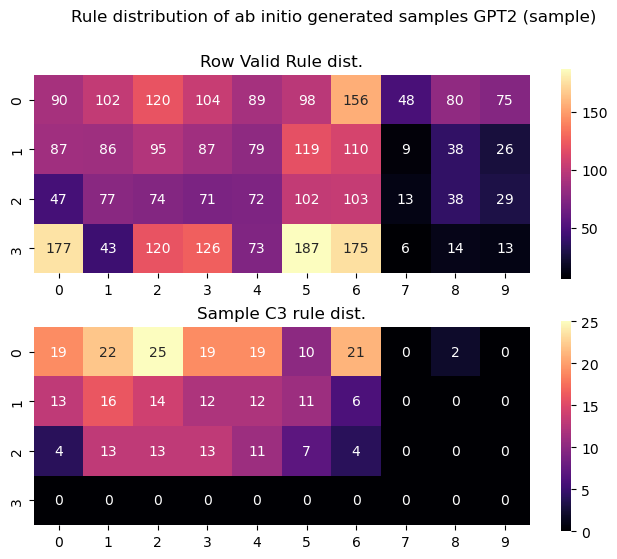

In [93]:
plt.subplots(2,1, figsize=(8,6))
plt.subplot(2,1,1)
sns.heatmap(rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
plt.axis('image')
plt.title("Row Valid Rule dist.")
plt.subplot(2,1,2)
sns.heatmap(C3_rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
plt.axis('image')
plt.title("Sample C3 rule dist.")
plt.suptitle("Rule distribution of ab initio generated samples GPT2 (sample)")

### Inpainting

In [18]:
print("Training samples final panel inpainting")
rnd_idx = np.random.choice(len(attr_seq_tsr_train), 512)
gpt2_raven.eval()
eval_samples = attr_seq_tsr_train[rnd_idx,:,:]
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples, gpt2_raven, num_mask=9, 
                                                                 device='cuda', strategy="greedy")

Training samples final panel inpainting
Completion: C3: 407/512,  valid: 1444/1536


In [19]:
print("Held out samples final panel inpainting")
rnd_idx = np.random.choice(len(attr_seq_tsr_val), 512)
gpt2_raven.eval()
eval_samples = attr_seq_tsr_val[rnd_idx,:,:]
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples, gpt2_raven, num_mask=9, 
                                                                 device='cuda', strategy="greedy")

Held out samples final panel inpainting
Completion: C3: 376/512,  valid: 1430/1536


In [39]:
class_val = torch.tensor([i for i in torch.arange(40) for _ in range(50)],dtype=torch.long)
class_val

tensor([ 0,  0,  0,  ..., 39, 39, 39])

In [27]:
print("Held out samples final panel inpainting [Greedy decoding]")
gpt2_raven.eval()
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(attr_seq_tsr_val, gpt2_raven, num_mask=9, 
                                                                 device='cuda', strategy="greedy", batch_size=512)

Held out samples final panel inpainting
Completion: C3: 0.739 [1478/2000],  valid: 0.931 [5586/6000]


#### Rule specific analysis

In [44]:
C3_arr = np.array(C3_list, dtype=object)
df_col = []
for rule in range(40):
    C3_per_rule = C3_arr[class_val == rule]
    # N_C3 = sum([len(x) > 0 for x in C3_per_rule])
    N_C3 = sum([rule in x for x in C3_per_rule])
    N_fail = sum([len(x) == 0 for x in C3_per_rule])
    # print(f"Rule {rule}: N_C3: {N_C3} ")#, N_fail: {N_fail}")
    df_col.append({"rule": rule, "N_C3": N_C3, "N_fail": N_fail, "ratio": N_C3 / len(C3_per_rule)})
df = pd.DataFrame(df_col)
acc_rate_mat = df.ratio.to_numpy().reshape(4,10)


In [55]:
def get_rule_annot():
    relation_dict = {
    0: "Constant",
    1: "Progression neg 2",
    2: "Progression neg 1",
    3: "Progression pos 1",
    4: "Progression pos 2",
    5: "Arithmetic pos",
    6: "Arithmetic neg",
    7: "XOR",
    8: "OR",
    9: "AND"
    }
    attribute_dict =  {0: "Shape", 1: "Size", 2: "Color", 3: "Number", 4: "Position"}
    rule_table = {}
    for i in range(40):
        if i < 37:
            rule_table[i] = f"{relation_dict[i%10]}-{attribute_dict[i//10]}"
        else:
            rule_table[i] = f"{relation_dict[i%10]}-{attribute_dict[i//10+1]}"
    return rule_table, relation_dict, attribute_dict

rule_table, relation_dict, attribute_dict = get_rule_annot()

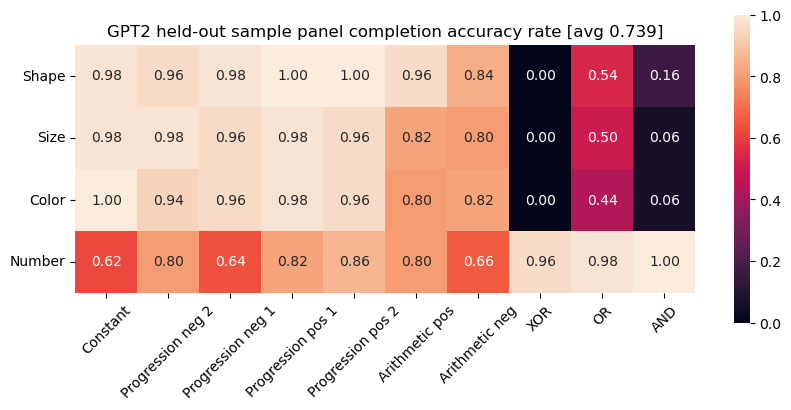

In [60]:
acc_rate_mat = df.ratio.to_numpy().reshape(4,10)
plt.figure(figsize=(10,4))
sns.heatmap(acc_rate_mat, annot=True, fmt=".2f")
plt.axis("image")
plt.title(f"GPT2 held-out sample panel completion accuracy rate [avg {acc_rate_mat.mean():.3f}]")
plt.xticks(ticks=np.arange(10)+0.5, labels=[relation_dict[i] for i in range(10)], rotation=45)
plt.yticks(ticks=np.arange(4)+0.5, labels=[attribute_dict[i] for i in range(4)], rotation=0)
plt.show()

In [96]:
# count number of total parameters 
total_params = sum(p.numel() for p in gpt2_raven.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 85156638


In [97]:
85156638 * 20 / 81

21026330.37037037

In [61]:
print("Held out samples final panel inpainting [Stochastic sampling]")
gpt2_raven.eval()
eval_complete, C3_list_stoch, C2_list, rule_col_list = completion_eval(attr_seq_tsr_val, gpt2_raven, num_mask=9, 
                                                                 device='cuda', strategy="sample", batch_size=512)

Held out samples final panel inpainting
Completion: C3: 0.613 [1225/2000],  valid: 0.900 [5402/6000]


In [62]:
C3_arr = np.array(C3_list_stoch, dtype=object)
df_col = []
for rule in range(40):
    C3_per_rule = C3_arr[class_val == rule]
    # N_C3 = sum([len(x) > 0 for x in C3_per_rule])
    N_C3 = sum([rule in x for x in C3_per_rule])
    N_fail = sum([len(x) == 0 for x in C3_per_rule])
    # print(f"Rule {rule}: N_C3: {N_C3} ")#, N_fail: {N_fail}")
    df_col.append({"rule": rule, "N_C3": N_C3, "N_fail": N_fail, "ratio": N_C3 / len(C3_per_rule)})
df = pd.DataFrame(df_col)
acc_rate_mat = df.ratio.to_numpy().reshape(4,10)

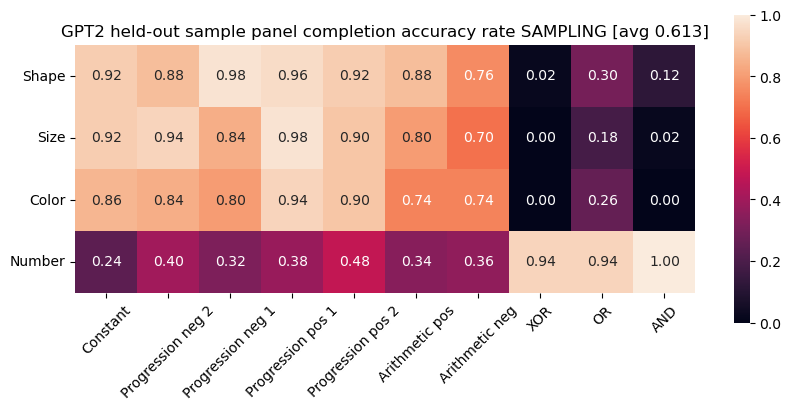

In [64]:
plt.figure(figsize=(10,4))
sns.heatmap(acc_rate_mat, annot=True, fmt=".2f")
plt.axis("image")
plt.title(f"GPT2 held-out sample panel completion accuracy rate SAMPLING [avg {acc_rate_mat.mean():.3f}]")
plt.xticks(ticks=np.arange(10)+0.5, labels=[relation_dict[i] for i in range(10)], rotation=45)
plt.yticks(ticks=np.arange(4)+0.5, labels=[attribute_dict[i] for i in range(4)], rotation=0)
plt.show()

### Failed Training

In [26]:
gpt2_raven = MultiIdxGPT2Model(attribute_dims=(7,10,10), vocab_size=27, max_length=83, n_embd=768, n_class=0)
# train loop
optimizer = AdamW(gpt2_raven.parameters(), lr=1e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=1000)
# dataset = torch.utils.data.TensorDataset(attr_seq_tsr_pps)
data_loader = torch.utils.data.DataLoader(attr_seq_tsr_train, batch_size=64, shuffle=True)
gpt2_raven.train().to('cuda')
for epoch in range(50):
    gpt2_raven.train()
    pbar = tqdm(data_loader)
    for inputs in pbar:
        inputs = inputs.cuda()
        optimizer.zero_grad()
        outputs, logits_attr1, logits_attr2, logits_attr3 = gpt2_raven(inputs)
        loss = multi_attr_loss([logits_attr1[:,:-1], logits_attr2[:,:-1], logits_attr3[:,:-1]], inputs)
        # loss = next_token_loss((attr_seq_tsr_1, attr_seq_tsr_2, attr_seq_tsr_3), inputs)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'Loss: {loss.item()}')
        # print(loss.item())
    
    rnd_idx = np.random.choice(len(attr_seq_tsr_val), 512)
    gpt2_raven.eval()
    eval_samples = attr_seq_tsr_val[rnd_idx,:,:]
    eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples, gpt2_raven, num_mask=9, device='cuda', strategy="greedy")
    torch.save({"eval_complete": eval_complete, "C3_list": C3_list, "C2_list": C2_list, "rule_col_list": rule_col_list}, f"eval_epoch{epoch}.pt")

  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 0/512,  valid: 0/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 12/512,  valid: 135/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 32/512,  valid: 344/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 35/512,  valid: 364/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 28/512,  valid: 336/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 26/512,  valid: 318/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 26/512,  valid: 321/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 29/512,  valid: 330/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 24/512,  valid: 320/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 33/512,  valid: 292/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 34/512,  valid: 288/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 28/512,  valid: 280/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 26/512,  valid: 277/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 33/512,  valid: 288/512


  0%|          | 0/2469 [00:00<?, ?it/s]

Completion: C3: 35/512,  valid: 294/512


  0%|          | 0/2469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [62]:
th.save(gpt2_raven.state_dict(), 'gpt2_raven.pth')

In [26]:
gpt2_raven = MultiIdxGPT2Model(attribute_dims=(7,10,10), vocab_size=27, max_length=83, n_embd=768, n_class=0)
gpt2_raven.load_state_dict(th.load('gpt2_raven.pth'))

<All keys matched successfully>

In [18]:
outputs.last_hidden_state.shape

torch.Size([208, 82, 768])

In [27]:
val_loader = torch.utils.data.DataLoader(attr_seq_tsr_val, batch_size=256, shuffle=True)
gpt2_raven.eval().cuda()
pbar = tqdm(val_loader)
loss_sum = []
for inputs in pbar:
    inputs = inputs.cuda()
    with torch.no_grad():
        outputs, logits_attr1, logits_attr2, logits_attr3 = gpt2_raven(inputs)
        loss = multi_attr_loss_vec([logits_attr1[:,:-1], logits_attr2[:,:-1], logits_attr3[:,:-1]], inputs)
    # loss = next_token_loss((attr_seq_tsr_1, attr_seq_tsr_2, attr_seq_tsr_3), inputs)
    pbar.set_description(f'Loss: {loss.item()}')
    # print(loss.item())
    loss_sum.append(loss.item())
print(np.mean(loss_sum))

  0%|          | 0/8 [00:00<?, ?it/s]

1.216092293532256e-08


In [11]:
val_loader = torch.utils.data.DataLoader(attr_seq_tsr_val, batch_size=256, shuffle=True)
gpt2_raven.eval().cuda()
pbar = tqdm(val_loader)
loss_sum = []
for inputs in pbar:
    inputs = inputs.cuda()
    with torch.no_grad():
        outputs, logits_attr1, logits_attr2, logits_attr3 = gpt2_raven(inputs)
        loss = multi_attr_loss([logits_attr1[:,:-1], logits_attr2[:,:-1], logits_attr3[:,:-1]], inputs)
    # loss = next_token_loss((attr_seq_tsr_1, attr_seq_tsr_2, attr_seq_tsr_3), inputs)
    pbar.set_description(f'Loss: {loss.item()}')
    # print(loss.item())
    loss_sum.append(loss.item())
print(np.mean(loss_sum))

  0%|          | 0/8 [00:00<?, ?it/s]

5.312208572333388e-11


In [32]:
(logits_attr1.argmax(-1)[:,1:] == inputs[:, :, 0]).float().mean()

tensor(0.4639, device='cuda:0')

In [ ]:
next_token_loss((logits_attr1[:,1:], logits_attr2[:,1:], logits_attr3[:,1:]), inputs[:,])

In [53]:
eval_samples = attr_seq_tsr_pps[10020:10040]
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples, gpt2_raven, num_mask=54, device='cuda', strategy="sample")

Completion: C3: 0/20,  valid: 10/20


In [46]:
eval_samples = attr_seq_tsr_pps[:50]
eval_complete = sample_next_token(gpt2_raven, eval_samples[:, :-9, :], max_length=81, 
                                  strategy="sample", device="cuda").cpu() #sample
img_tsr_complete = seqtsr2imgtsr(eval_complete, )
C3_list, C2_list, rule_col_list = infer_rule_from_sample_batch(img_tsr_complete-1)
C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(C3_list, C2_list, rule_col_list)
print(f"Completion: C3: {C3_count}/{total},  valid: {anyvalid_count}/{total*3}")

Completion: C3: 0/50,  valid: 109/150


In [138]:
C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(C3_list, C2_list, rule_col_list)

In [101]:
eval_complete.shape

torch.Size([10, 81, 3])

### Scratch zone

In [ ]:
gpt2_raven.context_embed(torch.zeros(2, dtype=th.long)).shape

torch.Size([2, 768])

In [68]:
attr_seq_tsr_pps[:30].shape

torch.Size([30, 81, 3])

In [69]:
gpt2_raven.sep_word_embed(attr_seq_tsr_pps[:30]).shape

torch.Size([30, 81, 768])

In [77]:
outputs, attr_seq_tsr_1, attr_seq_tsr_2, attr_seq_tsr_3 = gpt2_raven(attr_seq_tsr_pps[:30])

In [79]:
attr_seq_tsr_2.shape

torch.Size([30, 81, 11])

In [81]:
attr_seq_tsr_pps[:30,].shape

torch.Size([30, 81, 3])

In [37]:
embedding1(attr_seq_tsr_pps[:5,:,0]).shape

torch.Size([5, 81, 256])

In [23]:
attr_tsr.shape

torch.Size([40, 4000, 3, 9, 9])

In [ ]:
# Define the training and validation datasets
# train_dataset = TextDataset(
#     tokenizer=tokenizer,
#     file_path="train.txt",
#     block_size=128
# )
# valid_dataset = TextDataset(
#     tokenizer=tokenizer,
#     file_path="valid.txt",
#     block_size=128
# )

# Define a data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./gpt2", # The output directory
    overwrite_output_dir=True, # Overwrite the content of the output directory
    num_train_epochs=3, # Number of training epochs
    per_device_train_batch_size=32, # Batch size for training
    per_device_eval_batch_size=64, # Batch size for evaluation
    eval_steps = 400, # Number of update steps between two evaluations
    save_steps=800, # Number of updates steps before two checkpoint saves
    warmup_steps=500, # Number of warmup steps for learning rate scheduler
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)

# Train the model
trainer.train()